In [25]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity

import torch
from torchvision.datasets import CIFAR10, MNIST
import torchvision.transforms as transforms
from torch.optim import Adam

from kfp import construct_A, construct_B, diffusion_coeff, construct_R, construct_P, construct_P_block, construct_R_block, gauss_seidel, solve_pde, logsumexp
from network import ScoreNet

import PIL

#torch.set_default_device('cuda')

# create a.so if doesnt exists
if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
    os.system("make -C ../sparse_gaussian_elimination a.so")


cifar = CIFAR10('.', download=True)
np.random.seed(2)


# download mnist dataset
#data_loader = DataLoader(list(filter(lambda i: i[1] == 5, mnist))[:1], shuffle=True, generator=torch.Generator(device='cuda'))
cifar_data = cifar.data[np.array(cifar.targets) == 5] # grab the fives

# sample 5 images for training
cifar_data = cifar_data[np.random.choice(list(range(len(cifar_data))), 1, replace=False)]

Files already downloaded and verified


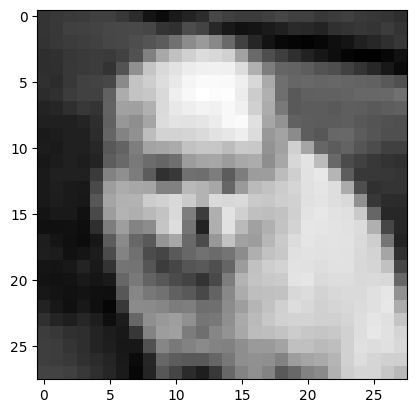

In [26]:

cifar_data = [torch.Tensor(np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("L").crop((0, 0, 28, 28))))]
plt.imshow(cifar_data[0], cmap="gray")

In [27]:
## construct the grid and Initial values
batch_size = 32
N = 5
H = 28
W = 28
epoch = 15
eps = 1e-6

t = np.linspace(eps, 1, N)
dt = 1/N

sigma = 25

# create model
model_score = ScoreNet(H=H, W=W)
loss_fn = torch.nn.MSELoss()
optimizer = Adam(model_score.parameters(), lr=1e-3)
mm_scaler = MinMaxScaler()
model_score.train();

  0%|          | 0/15 [00:00<?, ?it/s]

tensor(115.3644) tensor(-109.4715)


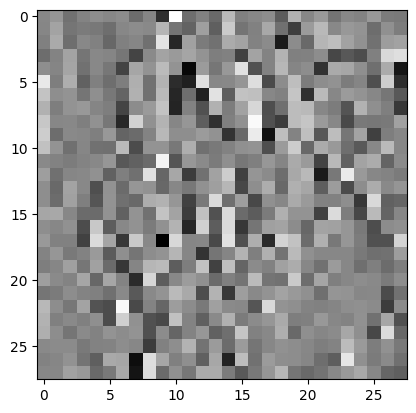

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


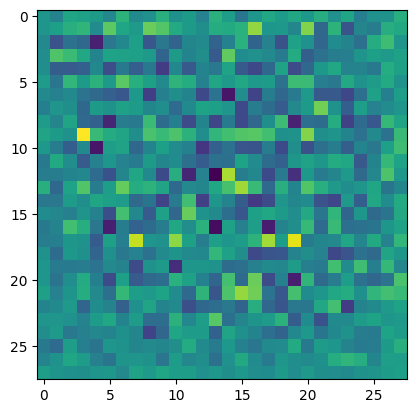

  7%|▋         | 1/15 [00:01<00:25,  1.80s/it]

tensor(101.9108) tensor(-130.0348)


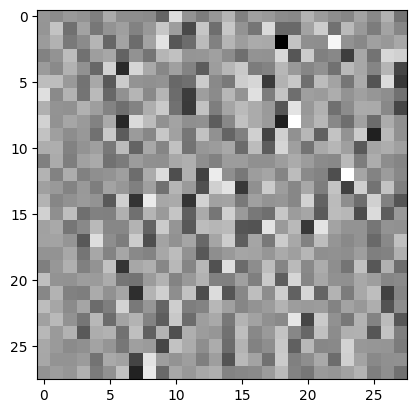

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


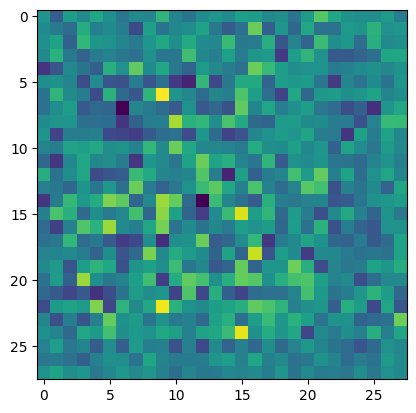

 13%|█▎        | 2/15 [00:02<00:17,  1.36s/it]

tensor(148.6636) tensor(-113.9948)


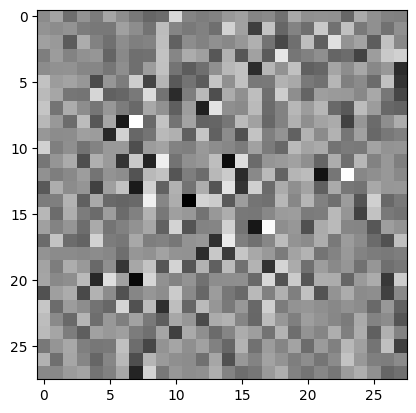

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


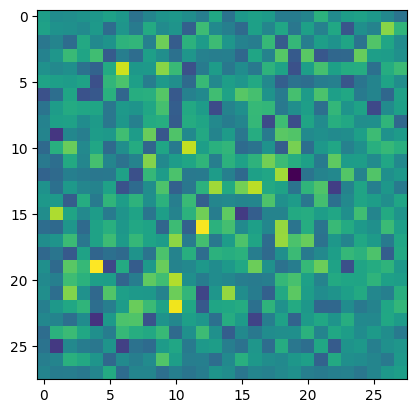

 20%|██        | 3/15 [00:03<00:12,  1.05s/it]

tensor(104.1873) tensor(-110.6023)


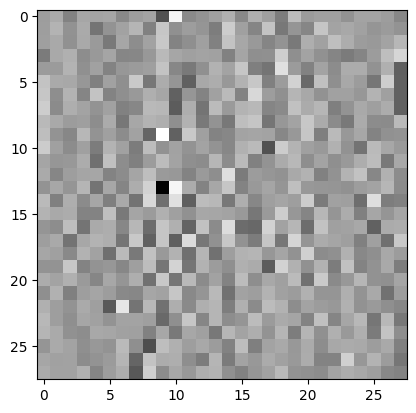

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


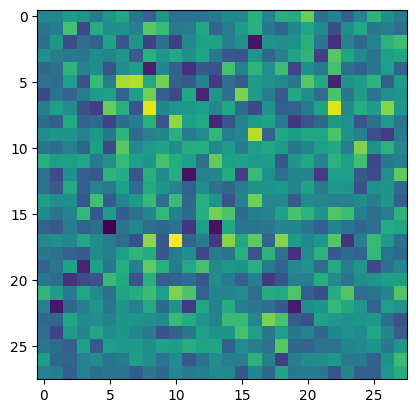

 27%|██▋       | 4/15 [00:04<00:09,  1.16it/s]

tensor(108.7383) tensor(-136.0153)


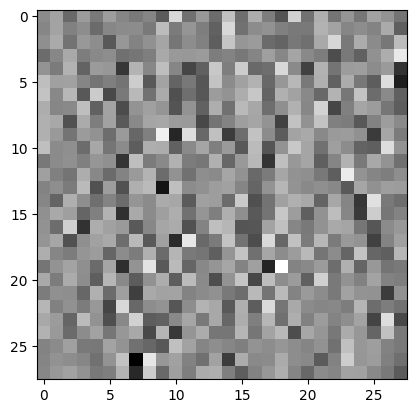

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


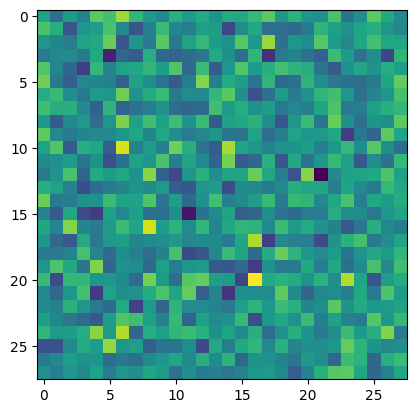

 33%|███▎      | 5/15 [00:04<00:07,  1.28it/s]

tensor(107.4486) tensor(-117.6464)


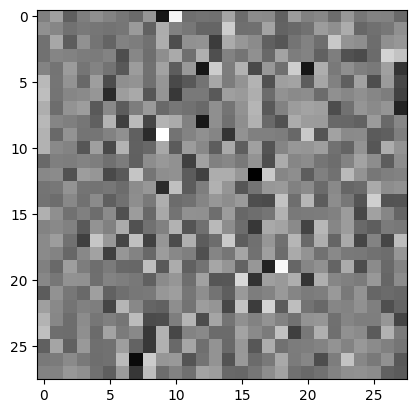

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


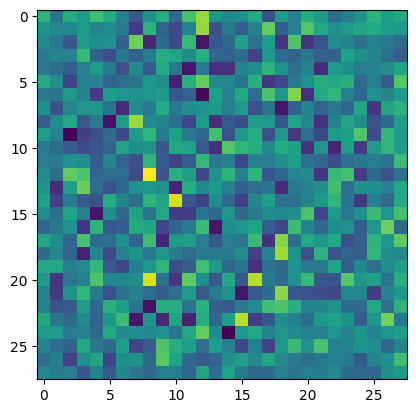

 40%|████      | 6/15 [00:05<00:06,  1.37it/s]

tensor(93.3014) tensor(-111.9224)


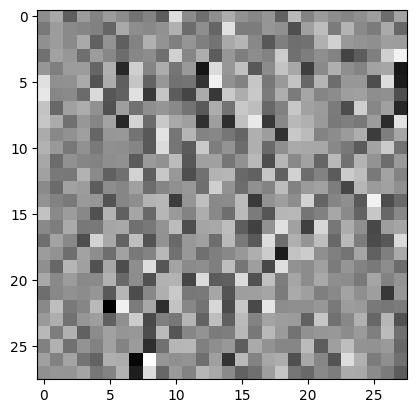

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


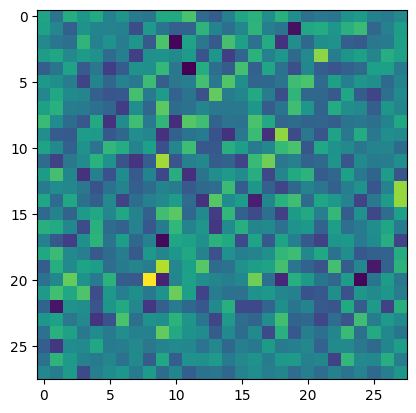

 47%|████▋     | 7/15 [00:06<00:05,  1.40it/s]

tensor(101.7942) tensor(-105.0292)


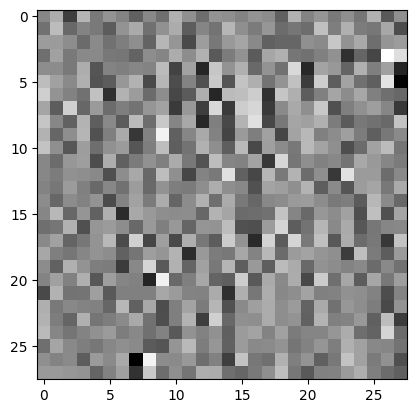

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


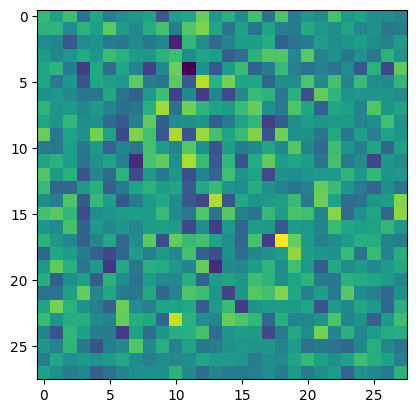

 53%|█████▎    | 8/15 [00:06<00:04,  1.49it/s]

tensor(133.8698) tensor(-102.5375)


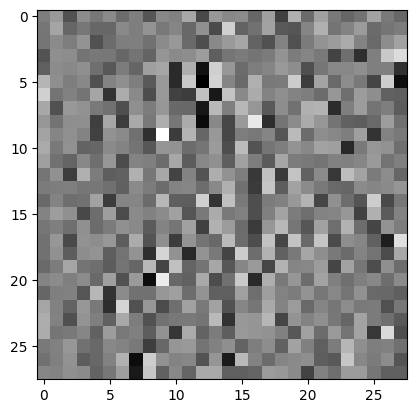

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


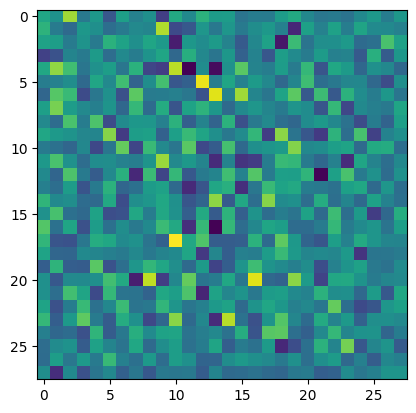

 60%|██████    | 9/15 [00:07<00:04,  1.46it/s]

tensor(105.3855) tensor(-115.7192)


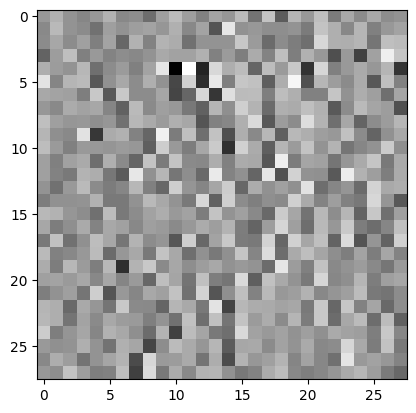

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


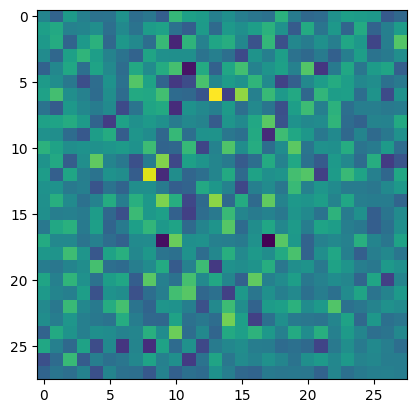

 67%|██████▋   | 10/15 [00:07<00:03,  1.59it/s]

tensor(110.5288) tensor(-113.1785)


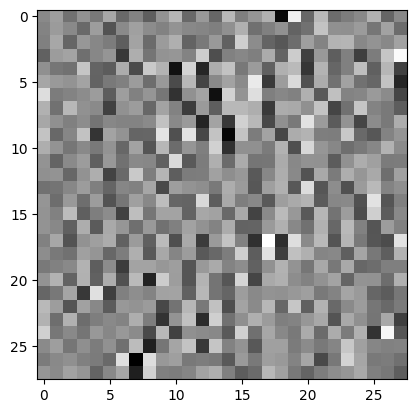

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


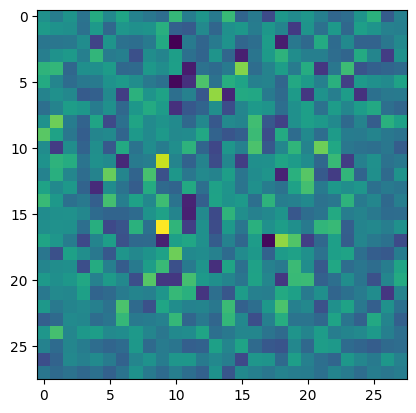

 73%|███████▎  | 11/15 [00:08<00:02,  1.74it/s]

tensor(96.7369) tensor(-100.4153)


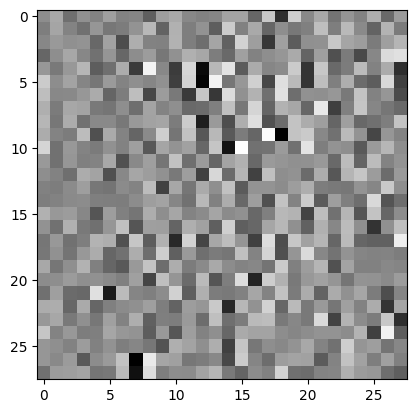

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


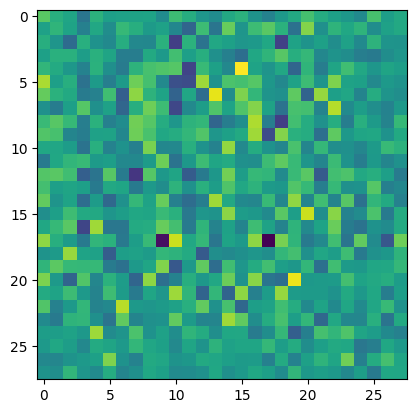

 80%|████████  | 12/15 [00:09<00:01,  1.63it/s]

tensor(118.9214) tensor(-116.5878)


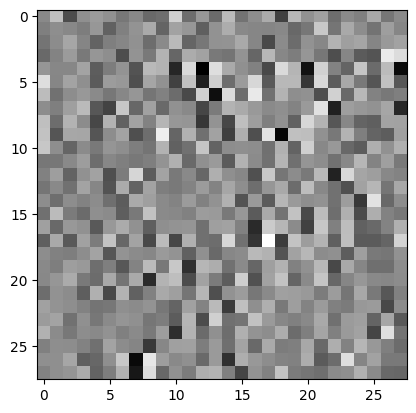

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


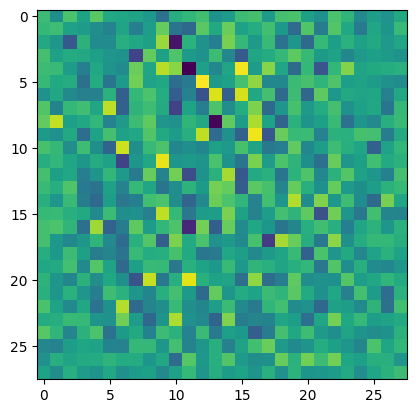

 87%|████████▋ | 13/15 [00:09<00:01,  1.47it/s]

tensor(106.7482) tensor(-107.8403)


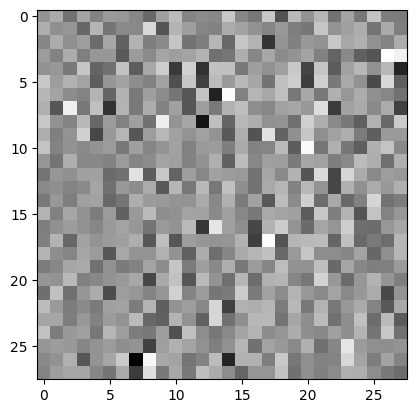

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


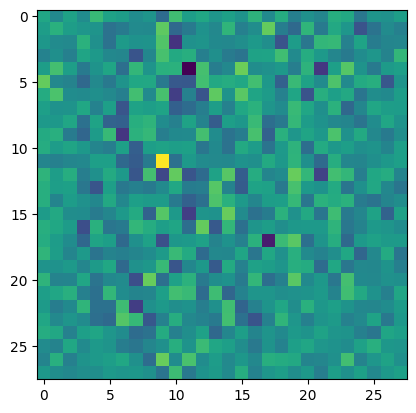

 93%|█████████▎| 14/15 [00:10<00:00,  1.41it/s]

tensor(106.6389) tensor(-98.4647)


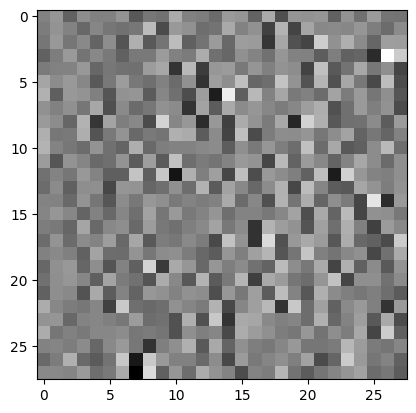

torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])
torch.Size([5, 128, 5, 5]) torch.Size([5, 128, 5, 5])


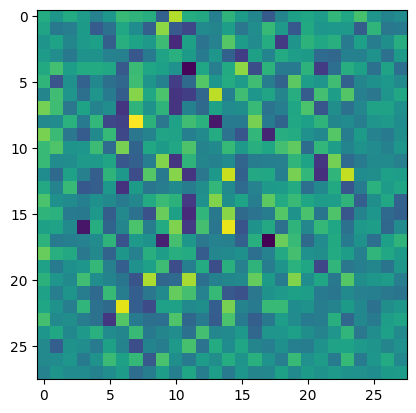

100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


model has been saved


In [28]:
# we want to sample from random time steps to construct training samples
random_t = np.random.rand(N-3)
random_t = np.insert(random_t, 0, dt) # first step we want something small
random_t = np.insert(random_t, 0, 1)
random_t = np.sort(random_t) # we sort the time in increasing order for denoising
time_ = np.insert(random_t, 0, eps).astype(np.float32) # for denoising we want time 0 to always be in sample to train
sigma_ = diffusion_coeff(torch.tensor(time_), sigma).detach().cpu().numpy()
scores = np.zeros((len(cifar_data) ,N, H, W), dtype=np.float32)



for e in tqdm(range(epoch)):

  for idx, x_ in enumerate(cifar_data):
    data = x_
    
    x = torch.zeros((N, 1, H, W))
    m = np.zeros((N, H*W), dtype=np.float32)
    del_m = np.zeros_like(m, dtype=np.float32)
    m_c = np.zeros((N, int((H*W/4))), dtype=np.float32)

    dx = data.detach().numpy().max()/H
    dy = data.detach().numpy().max()/W
    x[0] = torch.tensor(mm_scaler.fit_transform(data.ravel()[:, None]).astype(np.float32)).reshape((1, 1, H, W))
    kde = KernelDensity(kernel='gaussian').fit(data.ravel()[:, None])
    m[0] = kde.score_samples(data.ravel()[:, None])
    del_m[0] = np.diff(m[0].ravel(), axis=0, prepend=m[0,0])
    del_m_c = np.zeros_like(m_c, dtype=np.float32)

    perturbed_x = torch.zeros_like(x)

    #for e in tqdm(range(epoch)):
      # we normalize for sigma to ensure the dynamics doesn't blow up
    A_block = []
    for i, t_ in enumerate(random_t, 1):
      A = construct_A(dx, dy, t_ - time_[i-1], np.zeros((H, W)), sigma_[i], scores[idx][i], H, W)
      if i == 1:
        A_block = sp.linalg.block_diag(A)
      else:
        A_block = sp.linalg.block_diag(A_block, A)
        A_block[(i-1)*H*W:i*H*W, (i-2)*H*W:(i-1)*H*W] = -np.eye((H*W))/(t_ - time_[i-1])

    B = construct_B(dx, dy, time_[1] - time_[0], m[0], np.zeros((H, W)), sigma_[1], scores[idx][1])
    B_block = np.zeros(A_block.shape[0])
    B_block[:H*W] = B

    # update m (pre-smoothing)
    m[1:] = gauss_seidel(A_block, B_block, scores[idx][1:].flatten()).reshape(((N-1), H*W))
    R = construct_R(int(H/2), int(H))
    P = construct_P(R)
    R_block = []
    P_block = []
    for i, t_ in enumerate(random_t, 1):
      ####### kernal preserving restriction ####
      R_block = construct_R_block(R, R_block, i)
      ####### bilinear interpolation ###########
      P_block = construct_P_block(P, P_block, i)

    # we want to perform the coarse grid
    # compute residual r = b - Am[1:]
    r = B_block - A_block@m[1:].flatten()
    # coursening step 1: r_c = R_c@r
    r_c = R_block@r
    # coursening A_c = R_c@A@P_c (Petrov-Galerkin Coursening)
    A_c = R_block@A_block@P_block
    # compute course err: err_c = solve_pde(A_c,r_c)
    err_c = solve_pde(A_c, r_c, mode='sparse')
    # interpolate to fine grid: err = P_c@err_c
    err = P_block@err_c
    # we apply fine grid-correction
    m[1:] = (m[1:].flatten() + err).reshape((N-1, H*W))
    # post smoothing
    m[1:] = gauss_seidel(A_block, B_block, m[1:].flatten()).reshape(((N-1), H*W))
    # we want to coarsen the score function to train on coarse data
    m_c[1:] = (R_block@m[1:].flatten()).reshape((-1, int(H*W/4)))

    # constructing the training data and labels
    for i, t_ in enumerate(random_t, 1):
      del_m[i] = np.diff(m[i].ravel(), axis=0, prepend=m[i, 0])

    x = torch.tensor(mm_scaler.fit_transform(np.exp((-m.ravel() - logsumexp(-m.ravel())))[:, None])).reshape((N, 1, H, W))
    perturbed_x = x + torch.randn_like(x) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None, None]
    print(perturbed_x.max(), perturbed_x.min())

    train_x_data = perturbed_x
    train_y_data = torch.tensor(del_m.astype(np.float32)).reshape((N, 1, H, W))

    plt.imshow(train_y_data[-1].reshape((H, W)), cmap="gray")
    plt.show()
    # generate coarse dataset
    x_c = torch.tensor(mm_scaler.fit_transform(np.exp((-m_c.ravel() - logsumexp(-m_c.ravel())))[:, None])).reshape((N, 1, int(H/2), int(W/2)))
    perturbed_xc = x_c + torch.randn_like(x_c) * torch.sqrt(2 * torch.tensor(sigma_)**2)[:, None, None, None]
    train_xc_data = perturbed_xc
    yc_pred = model_score(train_xc_data, torch.tensor(time_), coarse=True)
    lm = (2*torch.tensor(sigma_)**2)[:, None, None, None]
    loss = loss_fn(yc_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()

    y_pred = model_score(train_x_data, torch.tensor(time_))
    lm = (2*torch.tensor(sigma_)**2)[:, None, None, None]
    loss = loss_fn(y_pred/lm, train_y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses = loss.item()

    scores[idx] = (y_pred/lm).clone().detach().cpu().numpy().reshape((N, H, W)) # we normalize before fedding back into PDE
    plt.imshow(scores[idx][0].reshape((H, W))) # so we can see that the score should look something like this after training
    plt.show()

torch.save(model_score.state_dict(), 'model_cifar.pth')
print(f"\nmodel has been saved")